# Импортирование необходимых библиотек

In [1]:
import numpy as np 
import tensorflow as tf
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications import Xception
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Предобработка данных

Указание переменн-констант, которые будут использоваться по ходу выполнения кода.

In [2]:
TEST_DIR = "/kaggle/input/cats-and-dogs-image-classification/test"
TRAIN_DIR = "/kaggle/input/cats-and-dogs-image-classification/train"
BATCH_SIZE = 20
IMAGE_SHAPE = (256, 256, 3)
N_EPOCHS = 30

Создание функции get_images, которая находит количество картинок кошек и собак в директории train и test.

In [3]:
empty_files = []

def get_images(directory):
    dictionary = {'dogs' : [], 'cats' : []}
    for root_dir, cur_dir, files in os.walk(directory):
        for file in files:
            file_dir = os.path.join(root_dir, file)
            if os.path.getsize(file_dir) == 0:
                empty_files.append(file_dir)
            elif os.path.basename(os.path.normpath(root_dir)) == 'dogs':
                dictionary['dogs'].append(file_dir)
            elif os.path.basename(os.path.normpath(root_dir)) == 'cats':
                dictionary['cats'].append(file_dir)
    return dictionary

In [4]:
train_files = get_images(TRAIN_DIR)
test_files = get_images(TEST_DIR)
print(f"Количество картинок в тренировочной выборке - {len(train_files['cats']) + len(train_files['dogs'])},\
среди них котов - {len(train_files['cats'])} \
и собак - {len(train_files['dogs'])}")
print(f"Количество картинок в тестовой выборке - {len(test_files['cats']) + len(test_files['dogs'])},\
среди них котов - {len(test_files['cats'])} \
и собак - {len(test_files['dogs'])}")
print(f"Общее количество картинок в данных - {len(train_files['cats']) + len(train_files['dogs']) + len(test_files['cats']) + len(test_files['dogs'])}")
print(f"Пустых картинок - {len(empty_files)}")

Количество картинок в тренировочной выборке - 557,среди них котов - 279 и собак - 278
Количество картинок в тестовой выборке - 140,среди них котов - 70 и собак - 70
Общее количество картинок в данных - 697
Пустых картинок - 0


Создание объектов ImageDataGenerator - генераторов картинок для тренировочного и тестового датасетов. Для тренировочного датасета также будет применяться аугментация. В данном случае она необходима так как размеры тренировочных данных невелики - всего 557 картинок.

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

Заполнение генераторов данными из директорий с тренировочными и тестовоми данными.

In [6]:
train_gen = train_datagen.flow_from_directory(TRAIN_DIR, batch_size = BATCH_SIZE, class_mode = 'binary')
test_gen = test_datagen.flow_from_directory(TEST_DIR, batch_size = BATCH_SIZE, class_mode = 'binary', shuffle=False)
class_names = ['cat', 'dog']

Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


Посмотрим на аугментированные картинки:

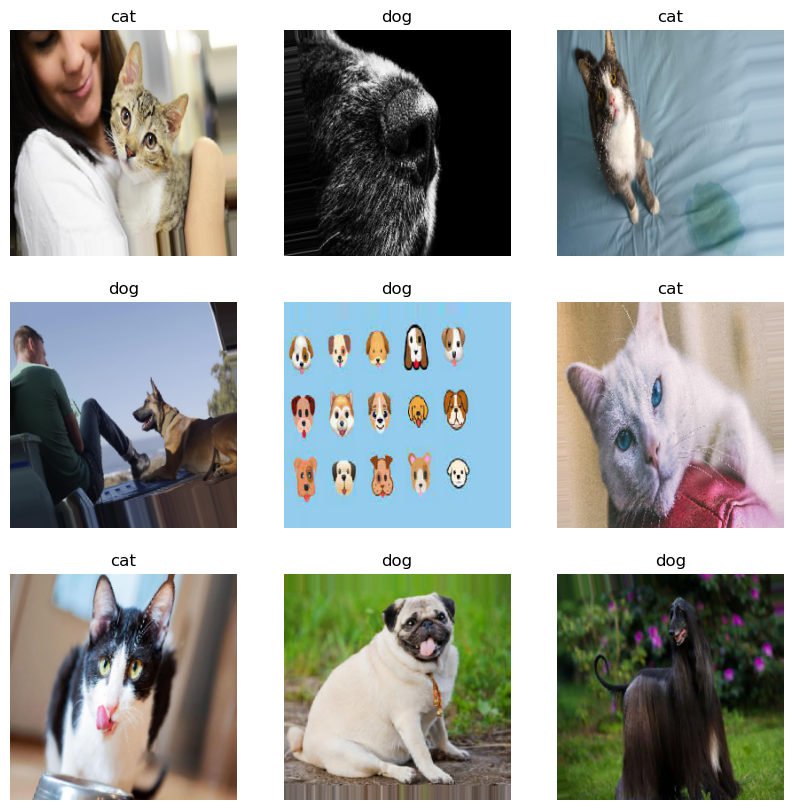

In [7]:
plt.figure(figsize=(10, 10))
i = 0
for images, labels in train_gen:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
    i += 1
    if i == 9:    break

Теперь можно создавать нейронную сеть. Для начала можно попробовать построить нейронную сеть самому. Мною была выбрана стандартная архитектура свёрточной нейронной сети - сначала идёт несколько ( в моём случае 4) блока свёрток (Свёртка+Батч Нормализация+Пулинг), после - полносвязная часть, с скрытым слоем и слоем с одним нейроном и сигмоидой для преобразования выхода в диапазон от 0 до 1.

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=IMAGE_SHAPE),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Всего в модели, как видим, 13 840 321 обучающих параметра - не так много для современных сетей. Далее, происходит компиляция нейронной сети - настройка функции ошибки (бинарная кросс-энтропия), оптимизатора - Adam, метрики - точность.

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

Тут происходит обучение нейронной сети на генераторе аугментировнных тренировочных картинок. Обучение ведётся именно на нём, так как при обучении на обычных данных, модель быстро переобучается - точность на тренировочных данных достигает 100 процентов, а на тестовых 65.

In [10]:
history = model.fit(
      train_gen,
      epochs=N_EPOCHS)

Epoch 1/30
28/28 [==============================] - 24s 550ms/step - loss: 1.0808 - accuracy: 0.5871
Epoch 2/30
28/28 [==============================] - 14s 504ms/step - loss: 0.8733 - accuracy: 0.5655
Epoch 3/30
28/28 [==============================] - 15s 518ms/step - loss: 0.6590 - accuracy: 0.6463
Epoch 4/30
28/28 [==============================] - 14s 494ms/step - loss: 0.6302 - accuracy: 0.6535
Epoch 5/30
28/28 [==============================] - 15s 522ms/step - loss: 0.5824 - accuracy: 0.6876
Epoch 6/30
28/28 [==============================] - 14s 493ms/step - loss: 0.5782 - accuracy: 0.7056
Epoch 7/30
28/28 [==============================] - 15s 524ms/step - loss: 0.5767 - accuracy: 0.7020
Epoch 8/30
28/28 [==============================] - 14s 509ms/step - loss: 0.5094 - accuracy: 0.7612
Epoch 9/30
28/28 [==============================] - 15s 517ms/step - loss: 0.4976 - accuracy: 0.7504
Epoch 10/30
28/28 [==============================] - 14s 495ms/step - loss: 0.5048 - accura

In [11]:
print("BCE на тесте - {}, точность на тесте - {}".format(*model.evaluate(test_gen)))

7/7 [==============================] - 3s 371ms/step - loss: 0.8931 - accuracy: 0.6500
BCE на тесте - 0.8930944204330444, точность на тесте - 0.6499999761581421


Как видно, точность вышла достаточно не плохая, но есть способы повысить качество классификация - transfer learning. Данная техника заключается в загрузке предобученной модели на данных, схожих с собственными. Далее данная модель может быть обучена на своих данных либо через полную заморозку всех слоёв сети кроме последнего, либо же наоборот - полному обучению сети, а не последнего его слоя. Я использовал две предобученые модели - EfficientB4 и Xception.

# Xception

Архитектура Xception: данные сначала проходят через входной поток, затем через средний поток, который повторяется восемь раз, и, наконец, через выходной поток. Ниже приведена полная её полная структура.

![](https://www.researchgate.net/publication/351371226/figure/fig2/AS:1020996995792897@1620436061199/Architecture-of-the-Xception-deep-CNN-model.jpg)

Загрузка модели из Keras. Сразу же указывается размер входных изображений, отказ от последнего классифицирущего слоя и веса - обученные на imagenet.

In [12]:
base_model = Xception(input_shape = IMAGE_SHAPE, 
    include_top = False,
    weights = 'imagenet')

83683744/83683744 [==============================] - 1s 0us/step


C помощью графа вычислений создаётся новая модель которая является объединением преобученной части Xception и двух полносвязных слоёв с сигмоидой на конце. Веса модели не замораживаются, так как в процессе опытов выяснилось, что модель лучше работает при незамороженных весах.

In [13]:
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

xception_model = tf.keras.models.Model(base_model.input, x)

xception_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['acc'])


Обучаем модель на своих данных:

In [14]:
xcep_hist = xception_model.fit(train_gen, epochs = N_EPOCHS)

Epoch 1/30
28/28 [==============================] - 42s 585ms/step - loss: 1.7296 - acc: 0.5835
Epoch 2/30
28/28 [==============================] - 16s 571ms/step - loss: 0.4625 - acc: 0.8492
Epoch 3/30
28/28 [==============================] - 17s 586ms/step - loss: 0.3655 - acc: 0.8995
Epoch 4/30
28/28 [==============================] - 17s 574ms/step - loss: 0.2742 - acc: 0.8923
Epoch 5/30
28/28 [==============================] - 16s 566ms/step - loss: 0.1578 - acc: 0.9479
Epoch 6/30
28/28 [==============================] - 17s 584ms/step - loss: 0.2757 - acc: 0.9264
Epoch 7/30
28/28 [==============================] - 16s 562ms/step - loss: 0.1905 - acc: 0.9318
Epoch 8/30
28/28 [==============================] - 17s 594ms/step - loss: 0.1335 - acc: 0.9497
Epoch 9/30
28/28 [==============================] - 16s 572ms/step - loss: 0.1163 - acc: 0.9677
Epoch 10/30
28/28 [==============================] - 17s 599ms/step - loss: 0.1610 - acc: 0.9551
Epoch 11/30
28/28 [====================

In [15]:
print("BCE ошибка на тесте - {}, точность - {}".format(*xception_model.evaluate(test_gen, verbose=False)))

BCE ошибка на тесте - 0.2444286346435547, точность - 0.8928571343421936


Точность на тесте у Xception модели составила 90%. Изобразим график изменения качества модели по ходу обучения:

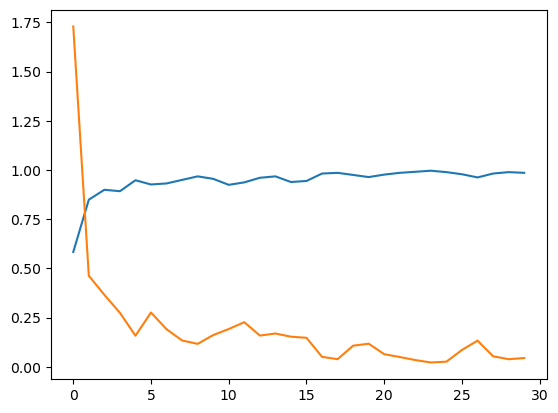

In [16]:
plt.plot(xcep_hist.history['acc'])
plt.plot(xcep_hist.history['loss']);

Несмотря на достаточно не плохие результаты у этой модели, также имеется другой тип моделей для классификации картинок, который называется EfficientNet. Если сравнивать по топ-1 точности, то этот тип имеет более высокие результаты (график приведён ниже).

![](https://warehouse-camo.ingress.cmh1.psfhosted.org/acfb05f8a49eb76db65cf17ac4455aa800f1ab37/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f74656e736f72666c6f772f7470752f6d61737465722f6d6f64656c732f6f6666696369616c2f656666696369656e746e65742f6733646f632f706172616d732e706e67)

# EfficientNetB4

Попробуем теперь исходя из этого графика доообучить модель EfficientNetB4, которая на графике выше явным образом выделяется по качеству точность/кол-во параметров. Также как и в прошлый раз возмём предобученную на imagenet модель без последней части.

In [17]:
base_model = EfficientNetB4(input_shape = IMAGE_SHAPE, 
    include_top = False,
    weights = 'imagenet')

71686520/71686520 [==============================] - 0s 0us/step


Также запретим обучение всех слоём кроме двух добавленных к этой модели - полносвязного с 512 нейронами и 1 нейроном для классификации с сигмоидой. При обучении используется оптимизатор Adam, бинарная кроссэнтропия(логлосс), и точность в качестве метрики.

In [18]:
for layer in base_model.layers:
    layer.trainable = False
    
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_eff = tf.keras.models.Model(base_model.input, x)

model_eff.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['acc'])

Обучение EfficientB4 модели

In [19]:
eff_hist = model_eff.fit(train_gen, epochs = N_EPOCHS)

Epoch 1/30


2023-03-28 12:13:03.869490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


28/28 [==============================] - 27s 509ms/step - loss: 1.6856 - acc: 0.9048
Epoch 2/30
28/28 [==============================] - 15s 538ms/step - loss: 0.7085 - acc: 0.9713
Epoch 3/30
28/28 [==============================] - 15s 527ms/step - loss: 0.6144 - acc: 0.9659
Epoch 4/30
28/28 [==============================] - 15s 538ms/step - loss: 0.3225 - acc: 0.9785
Epoch 5/30
28/28 [==============================] - 15s 517ms/step - loss: 0.0998 - acc: 0.9856
Epoch 6/30
28/28 [==============================] - 15s 546ms/step - loss: 0.1531 - acc: 0.9910
Epoch 7/30
28/28 [==============================] - 15s 523ms/step - loss: 0.6412 - acc: 0.9838
Epoch 8/30
28/28 [==============================] - 15s 535ms/step - loss: 0.1363 - acc: 0.9874
Epoch 9/30
28/28 [==============================] - 15s 526ms/step - loss: 0.1357 - acc: 0.9892
Epoch 10/30
28/28 [==============================] - 15s 541ms/step - loss: 0.0053 - acc: 0.9982
Epoch 11/30
28/28 [==============================]

In [20]:
print("Ошибка на тесте - {}, точность на тесте - {}".format(*model_eff.evaluate(test_gen, verbose=False)))

Ошибка на тесте - 1.7291183471679688, точность на тесте - 0.9428571462631226


Изобразим изменение точности и ошибки с каждой эпохой:

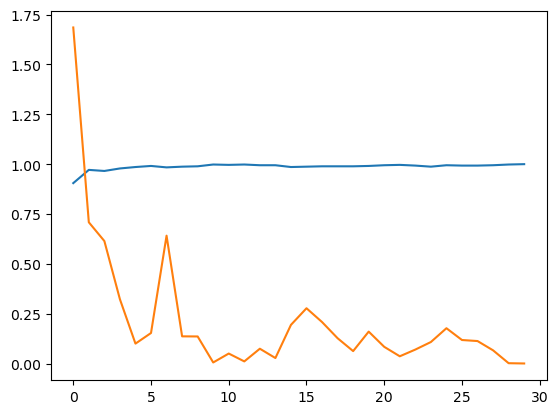

In [21]:
plt.plot(eff_hist.history['acc'])
plt.plot(eff_hist.history['loss']);

Качество на тестовой выборке у модели EfficientNet B4 - 96%. Если сравнивать все обученные выше три модели, то EfficientNet имеет самое высокое качество классификации среди них. Теперь можно построить confusion matrix для данной модели и изобразить предсказания.

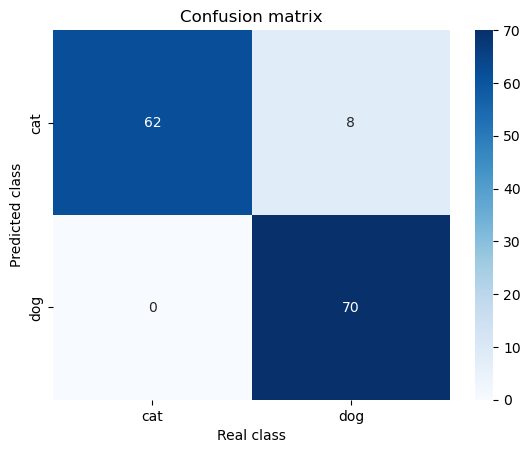

In [22]:
y_true = test_gen.labels
y_pred = (model_eff.predict(test_gen, verbose=False) > 0.5).reshape(-1).astype(int)

map_ = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues', yticklabels=['cat','dog'], xticklabels=['cat','dog'])
map_.set(xlabel="Real class", ylabel="Predicted class", title="Confusion matrix");

Теперь изобразим предсказания нейронной сети для 20 картинок:

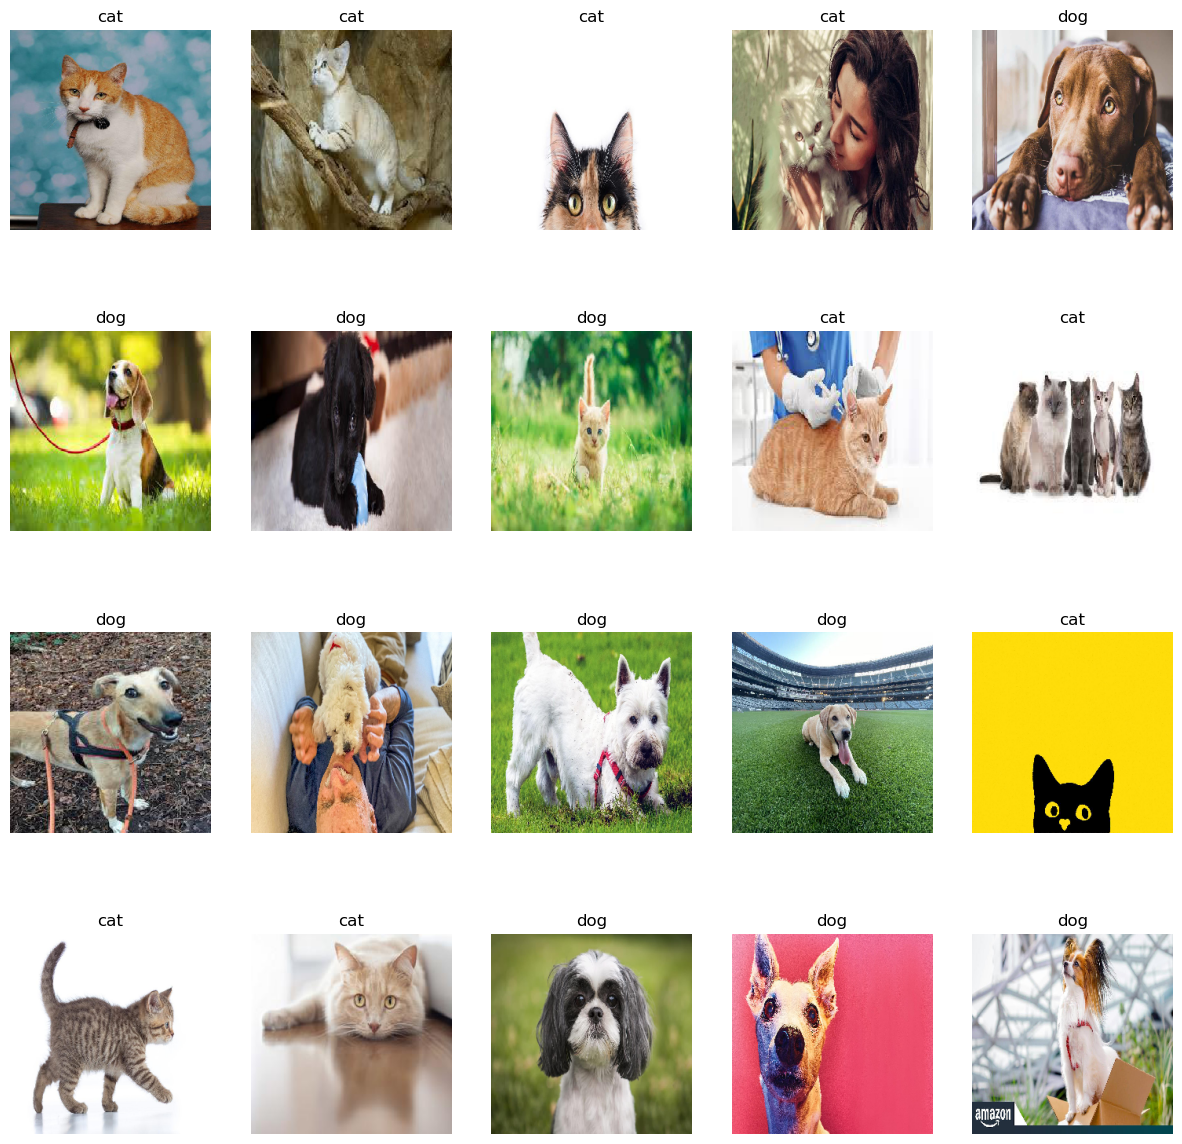

In [23]:
plt.figure(figsize=(15, 15))
i = 0
for images, labels in test_gen:
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].astype("uint8"))
    image = tf.expand_dims(images[i], 0)
    prediction = model_eff.predict(image, verbose=False)
    plt.title(class_names[int(prediction)])
    plt.axis("off")
    i += 1
    if i == 20:    break

# Заключение

Таким образом, среди всех 3 моделей наиболее удачной оказалась модель EfficientNet, из 140 объектов тестовой выборки только 5 она классифицировала как неправильные. Причём модель ошибочно предсказывала только котов. Также неплохое качество показала модель Xception - 90%. Возможно, при большем количестве эпох для обучения, она бы начала показывать результаты, схожие с Efficient, так как на кривой обучения видно, что качество со временем увеличивается. 